In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv(r"/content/vehicle insurance preprocessed.csv")

df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,22,1,7.0,1,0,0,2630.0,152.0,16,0
1,1,42,1,28.0,0,1,1,43327.0,26.0,135,0
2,0,66,1,33.0,0,1,1,35841.0,124.0,253,0
3,0,22,1,33.0,0,0,0,27645.0,152.0,69,0
4,1,28,1,46.0,1,0,0,29023.0,152.0,211,0


In [3]:
df.shape

(447906, 11)

In [4]:
# Independent and Dependent Features Split
x = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [5]:
# Calculate class weightage as there is class imbalance

num_negatives = (y == 0).sum()
num_positives = (y == 1).sum()
scale_pos_weight = num_negatives / num_positives

print(f"Class Weightage (scale_pos_weight): {scale_pos_weight:.2f}")

Class Weightage (scale_pos_weight): 5.15


In [6]:
# Train-test split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=44, shuffle=True, stratify=y)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.05, random_state=44, shuffle=True, stratify=y_train)

print("Training:", x_train.shape, y_train.shape)
print("Testing:", x_test.shape, y_test.shape)
print("Validation:", x_val.shape, y_val.shape)

Training: (361684, 10) (361684,)
Testing: (67186, 10) (67186,)
Validation: (19036, 10) (19036,)


In [2]:
cols = ['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',	'Vehicle_Age',	'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']

In [7]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train[cols] = scaler.fit_transform(x_train[cols])
x_train = pd.DataFrame(x_train)

x_val[cols] = scaler.transform(x_val[cols])
x_val = pd.DataFrame(x_val)

x_test[cols] = scaler.transform(x_test[cols])
x_test = pd.DataFrame(x_test)

# **XGBoost Model Training by applying Class Weightage**

In [11]:
# XGBoost Model Training
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Train an XGBoost model
model = XGBClassifier(scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='aucpr')
model.fit(x_train, y_train)

# Make predictions
y_val_pred = model.predict(x_val)

# Evaluate the model
print("Val Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print("\n Val Classification Report:")
print(classification_report(y_val, y_val_pred))

Val Confusion Matrix:
[[12171  3767]
 [  296  2802]]

 Val Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.76      0.86     15938
           1       0.43      0.90      0.58      3098

    accuracy                           0.79     19036
   macro avg       0.70      0.83      0.72     19036
weighted avg       0.89      0.79      0.81     19036



In [12]:
# Make predictions
y_pred = model.predict(x_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[43067 13186]
 [  939  9994]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.77      0.86     56253
           1       0.43      0.91      0.59     10933

    accuracy                           0.79     67186
   macro avg       0.70      0.84      0.72     67186
weighted avg       0.89      0.79      0.81     67186



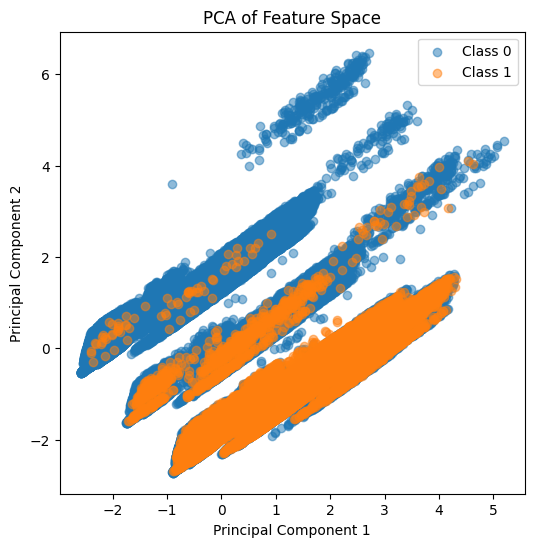

In [13]:
# Checking for Overlap between the two target variables using PCA

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6, 6))
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], label='Class 0', alpha=0.5)
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], label='Class 1', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.title('PCA of Feature Space')
plt.show()


In [14]:
# using under sampling techniques to remove overlap or noisy majority samples

from imblearn.under_sampling import EditedNearestNeighbours

enn = EditedNearestNeighbours(n_neighbors=5, n_jobs=-1)
X_resampled, y_resampled = enn.fit_resample(x, y)


In [15]:
y_resampled.value_counts()

,count
Response,
0,203518
1,72889


In [16]:
# using a combination of over sampling and under sampling technique to balance the dataset

from imblearn.combine import SMOTETomek

smote_t = SMOTETomek(n_jobs=-1)
X_resampled_new, y_resampled_new = smote_t.fit_resample(X_resampled, y_resampled)


In [17]:
y_resampled_new.value_counts()

,count
Response,
0,202825
1,202825


In [18]:
# Train-test split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_resampled_new, y_resampled_new, test_size=0.15, random_state=44, shuffle=True, stratify=y_resampled_new)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.05, random_state=44, shuffle=True, stratify=y_train)

print("Training:", x_train.shape, y_train.shape)
print("Testing:", x_test.shape, y_test.shape)
print("Validation:", x_val.shape, y_val.shape)

Training: (327561, 10) (327561,)
Testing: (60848, 10) (60848,)
Validation: (17241, 10) (17241,)


In [19]:
# Feature Scaling

x_train[cols] = scaler.fit_transform(x_train[cols])
x_train = pd.DataFrame(x_train)

x_val[cols] = scaler.transform(x_val[cols])
x_val = pd.DataFrame(x_val)

x_test[cols] = scaler.transform(x_test[cols])
x_test = pd.DataFrame(x_test)

# **XGBoost Model Training after balancing the dataset**

In [20]:
# XGBoost Model Training
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Train an XGBoost model
model = XGBClassifier(use_label_encoder=False, eval_metric='aucpr', random_state=44)
model.fit(x_train, y_train)

# Make predictions
y_val_pred = model.predict(x_val)

# Evaluate the model
print("Val Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print("\n Val Classification Report:")
print(classification_report(y_val, y_val_pred))

Val Confusion Matrix:
[[7878  743]
 [ 446 8174]]

 Val Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      8621
           1       0.92      0.95      0.93      8620

    accuracy                           0.93     17241
   macro avg       0.93      0.93      0.93     17241
weighted avg       0.93      0.93      0.93     17241



In [21]:
# Make predictions
y_pred = model.predict(x_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[27737  2687]
 [ 1633 28791]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93     30424
           1       0.91      0.95      0.93     30424

    accuracy                           0.93     60848
   macro avg       0.93      0.93      0.93     60848
weighted avg       0.93      0.93      0.93     60848

